# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Isotropic metrics

In this notebook, we solve isotropic eikonal equations on the CPU and the GPU, and  and check that they produce consistent results.

We obtain substantial accelerations on sufficiently large instances, a few million points, by a factor up to $100$. Note that smaller test cases yield less acceleration, due to the difficulty to extract parallelism.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

Error : ### 3 Multiprecision does not follow ## 2 Two dimensions, see Isotropic_Repro
[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1 Three dimensions](#1-Three-dimensions)
  * [2 Two dimensions](#2-Two-dimensions)
    * [3 Multiprecision](#3-Multiprecision)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Su

In [2]:
import cupy as cp
import numpy as np
import time
from matplotlib import pyplot as plt

In [3]:
from agd import HFMUtils
#from agd.HFMUtils import HFM_CUDA
from agd import AutomaticDifferentiation as ad
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

### 0.1 Decorations for gpu usage

Dealing with GPU data induces minor inconveniences:
- GPU arrays are not implicitly convertible to CPU arrays, and this is a good thing since memory transfers from GPU memory to CPU memory, and conversely, are not cheap. The `get` method must be applied to a cupy array to retrieve a numpy array.
- GPU computing is much more efficient with 32 bit data types, integer and floating point, than with their 64bit counterparts. However a number of numpy and cupy basic functions default to 64bit output, which will be inconsistent with the rest of computations.

We provide decorators to perform these memory transfers and data type conversions automatically. They are only applied to specific modules and functions, below, to avoid excessive implicit operations. 

In [5]:
cp = cugen.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = cugen.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,))

Casting output of function linspace from float64 to float32


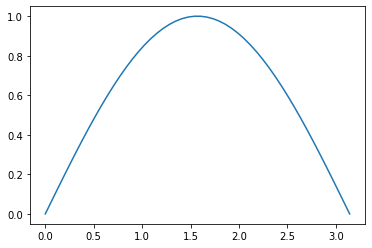

In [6]:
X = cp.linspace(0,np.pi) # 64 bit output is converted to 32 bit by decorator
plt.plot(X,np.sin(X));   # GPU array is transfered to CPU memory.

Note that, by default, these decorators do not apply to the system module, by only to a shallow copy.

In [7]:
sys.modules['cupy'].linspace(0,np.pi).dtype

dtype('float64')

In [8]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%5.3g" % x))

### 0.2 Utility functions

In [9]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

## 1 Three dimensions

GPU acceleration shines particularly well in three dimensions, where we get accelerations by a factor $100$ on common sizes.

In [10]:
n = 200 # Typical instance size
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic3',
    'seeds':[[0.,0.5,1.]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [11]:
RunCompare(hfmIn);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.12151789665222168 seconds, in 127 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 12.824 s.
Max |gpuValues-cpuValues| :  7.748603827462119e-07
Solver time (s). GPU : 0.12151789665222168, CPU : 12.824. Device acceleration : 105.53178053025115


By design, the CPU and GPU codes produce the same values, up to machine precision, which is approximately $10^{-8}$ for floating point types. This 'bit-for-bit' consistency is ensured as much as possible. We illustrate this behavior on small test cases.

In [12]:
n=50; hfmInS = hfmIn.copy() # Define the a smaller instance
hfmInS.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost':np.prod(np.sin(2*np.pi*X)) +1.1, # Non-constant cost
    'verbosity':0,
})

In [13]:
option_variants = [
    {},
    {"seedRadius":2},
    {"factorizationRadius":10,'factorizationPointChoice':'Key'}
]

In [14]:
for options in option_variants:
    print(f"\nReproducibility with options : {options}")
    RunCompare({**hfmInS,**options})


Reproducibility with options : {}
Max |gpuValues-cpuValues| :  4.64916229736545e-07
Solver time (s). GPU : 0.014030218124389648, CPU : 0.106. Device acceleration : 7.5551213145954765

Reproducibility with options : {'seedRadius': 2}
Max |gpuValues-cpuValues| :  4.64916229736545e-07
Solver time (s). GPU : 0.013499021530151367, CPU : 0.102. Device acceleration : 7.556103216234832

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}
Max |gpuValues-cpuValues| :  4.64916229736545e-07
Solver time (s). GPU : 0.01399993896484375, CPU : 0.102. Device acceleration : 7.285746049046321


## 2 Two dimensions

In two dimensions, it is usually more difficult to extract parallism than in three dimensions.
Indeed, the front propagated in the computations is expected to have approximately
$$
    N^{\frac{d-1} d}
$$
points in dimension $d$, where $N$ denotes the total number of points in the domain. 
The front in a two dimensional computation thus has $N^{\frac 1 2}$ points which is much fewer than $N^{\frac 2 3}$ in three dimensions, when $N$ is large. In addition the number of points $N$ is also often fewer in two dimensional problems.

In [15]:
n=4000
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.5]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [16]:
_,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.2584991455078125 seconds, in 251 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 10.424 s.
Max |gpuValues-cpuValues| :  7.016089529832126e-05
Solver time (s). GPU : 0.2584991455078125, CPU : 10.424. Device acceleration : 40.32508494185703


Another annoyance is that the numerical error, close to $10^{-4}$, is not as good as could be expected, around $10^{-7}$ for single precision floating point types. 
A quick fix, explained in more detail below and which does have a computational cost, is to run the computation using multiprecision.

In [17]:
gpuOut = RunGPU({**hfmIn,'multiprecision':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.42749619483947754 seconds, in 251 iterations.
Post-Processing
Max |gpuValues-cpuValues| :  1.2125012438524152e-07


In [18]:
n=200; hfmInS = hfmIn.copy() # Define a small instance 
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost':np.prod(np.sin(2*np.pi*X)) +1.1, # Non-constant cost
    'verbosity':0,
})

In [19]:
for options in option_variants:
    print(f"\nReproducibility with options : {options}")
    RunCompare({**hfmInS,**options})


Reproducibility with options : {}
Max |gpuValues-cpuValues| :  1.258254053060348e-06
Solver time (s). GPU : 0.008535385131835938, CPU : 0.015. Device acceleration : 1.7573899441340781

Reproducibility with options : {'seedRadius': 2}
Max |gpuValues-cpuValues| :  1.258254053060348e-06
Solver time (s). GPU : 0.005999565124511719, CPU : 0.015. Device acceleration : 2.5001812112541724

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}
Max |gpuValues-cpuValues| :  1.258254053060348e-06
Solver time (s). GPU : 0.006997823715209961, CPU : 0.015. Device acceleration : 2.143523559674287


### 3 Multiprecision

In multi-precision mode, the front values are represented as pairs 
$$
    u(x) = u_q(x) \delta + u_r(x),
$$
where $u_q(x) \in Z$ is an integer, $\delta>0$ is a fixed scale, and $u_r(x) \in [-\delta/2,\delta/2[$.

The parameter $\delta$ is set automatically as the largest power of two (usually a negative power) bounded by $h/10$, where $h$ is the grid scale. The choice of a power of two avoids roundoff errors.

Eventually, the result is converted to floating point format. A slightly better accuracy can be obtained by using a double type in this last step.

In [20]:
gpuOut = RunGPU({**hfmIn,'values_float64':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.3910200595855713 seconds, in 251 iterations.
Post-Processing
Max |gpuValues-cpuValues| :  6.194407586868067e-08
